<a href="https://colab.research.google.com/github/mibeaum/ML/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time classification**



Load Python modules

In [2]:
import numpy as np  # Arrays, matrices and functions on them. Required by Pandas, below
import pandas as pd # A data analysis library
from sklearn.model_selection import train_test_split # scikit-learn, machine learning tools
import matplotlib.pyplot as plt # A plotting library
import seaborn as sns # Built on matplotlib, facilitates aesthetically pleasing plots
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General settings
sns.set_style('whitegrid') # Plots will have a white grid
# Variables that will help us work with the classes
class_names = ['workstation', 'server']
class_colors = ['darkorange', 'steelblue']

classifier_3NN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
classifier_rf = RandomForestClassifier()
classifier_svc = SVC()

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Functions

In [11]:
def load_data(filename):
    
    downloaded = drive.CreateFile({'id':"1PIwZtFiMzzFgFkEjKSJYx8-mRUTyqkzN"})   # replace the id with id of file you want to access
    downloaded.GetContentFile(filename) 
 
    mydateparser = lambda x: ( 
       pd.to_datetime(x, format="%d/%m/%Y%H:%M:%S").strftime("%H")
    )    

    df = pd.read_csv(filename, sep=',', header=0, usecols = ["Server", "dateTime", "remoteIP"], parse_dates=['dateTime'], date_parser=mydateparser) # Use Pandas to load the data into a Pandas DataFrame
    df["dateTime"] = df["dateTime"].astype(float)
    df.sort_values(by=['dateTime'])
    print('Loaded from', filename)
    data = df.values # Convert from a Pandas DataFrame to a numpy array
    print('')
    return df

def plot_data_samples(df):
    ''' Plot the time series data relating to the input list of sample numbers '''
    plt.scatter(df['dateTime'], df['Server'])

    ylabels = [x for x in df['Server']]
    plt.yticks(df['Server'], ylabels)

    print('')
    #plt.set ylim([00.00, 23.59])
    plt.title('workstation (class 0): server (class 1)')
    plt.ylabel('Server')
    plt.xlabel('Time (Hours)') 


def plot_data(df):
    ''' Plot the time series data relating to the input list of sample numbers '''

    ylabels = [x for x in df['Server']]
    plt.yticks(df['Server'], ylabels)

    plt.title('workstation (class 0): server (class 1)')
    plt.ylabel('Server')
    plt.xlabel('Time (Hours)') 

    groups = df.groupby("diff")
    for name, group in groups:
       plt.plot(group["hour_pred"], group["Server"], marker="o", linestyle="", label=name)

    #plt.scatter(df['hour_pred'], df['server'], marker="o", linestyle="", label=df['diff'])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))   



    


Load the data

In [4]:
filename = 'dnsanom.csv'
df = load_data(filename) 
df.Server.replace(('Y', 'N'), (1, 0), inplace=True)
data_log = df.values # Convert from a Pandas DataFrame to a numpy array
print('These are the first 7 rows of data_log:\n', data_log[0:7], '\n')

Loaded from dnsanom.csv

These are the first 7 rows of data_log:
 [[15.0 '192.0.0.1' 1]
 [15.0 '192.0.0.1' 1]
 [15.0 '192.0.0.2' 0]
 [15.0 '192.0.0.2' 0]
 [15.0 '192.0.0.3' 1]
 [15.0 '192.0.0.4' 0]
 [15.0 '192.0.0.5' 1]] 



Process the data

In [5]:
labels = data_log[:,2].astype(int)
data = data_log[:,0:]
print('The shape of the labels vector is', labels.shape)
print('The shape of the data matrix is', data.shape)
print('The labels is a vector. These are the first 7 elements of labels vector:\n', labels[0:7], '\n')
print('The data is a matrix. These are the first 7 rows of data matrix:\n', data[0:7], '\n')



The shape of the labels vector is (890847,)
The shape of the data matrix is (890847, 3)
The labels is a vector. These are the first 7 elements of labels vector:
 [1 1 0 0 1 0 1] 

The data is a matrix. These are the first 7 rows of data matrix:
 [[15.0 '192.0.0.1' 1]
 [15.0 '192.0.0.1' 1]
 [15.0 '192.0.0.2' 0]
 [15.0 '192.0.0.2' 0]
 [15.0 '192.0.0.3' 1]
 [15.0 '192.0.0.4' 0]
 [15.0 '192.0.0.5' 1]] 



Plot the data

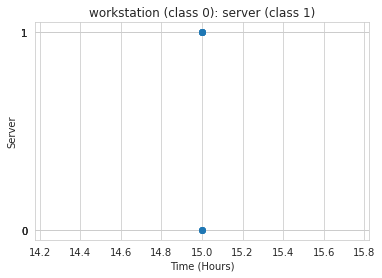

In [6]:
plot_data_samples(df[0:7]) 

Split the data set

In [7]:
test_size = 0.25

# Use the train_test_split from the scikit-learn (sklearn) module
# Splitting the data set so that each split is similar with respect to labels
# Split 75% to train and 25% to test 
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=test_size, stratify=labels)

print('The shape of data_train is', data_train.shape)
print('The shape of data_test is', data_test.shape)
print('Train data:')
print('Number of samples of class 0', (labels_train == 0).sum())
print('Number of samples of class 1', (labels_train == 1).sum())
#print('Number of samples of class unknown', (labels_train.any != 1 and labels_train.any != 0))
print('Test data:')
print('Number of samples of class 0', (labels_test == 0).sum())
print('Number of samples of class 1', (labels_test == 1).sum())

data_train[0:7]




The shape of data_train is (668135, 3)
The shape of data_test is (222712, 3)
Train data:
Number of samples of class 0 217213
Number of samples of class 1 450922
Test data:
Number of samples of class 0 72404
Number of samples of class 1 150308


array([[23.0, '192.0.1.0', 0],
       [16.0, '192.0.0.25', 1],
       [6.0, '192.0.0.208', 1],
       [6.0, '192.0.0.18', 1],
       [20.0, '192.0.0.25', 1],
       [4.0, '192.0.0.25', 1],
       [0.0, '192.0.0.224', 0]], dtype=object)

Train using the knearest neighbours classifier



In [8]:
classifier_3NN.fit(data_train[:,0].reshape(-1,1), labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Test using the knearest neighbours classifier

In [9]:
data_pred = classifier_3NN.predict(data_test[:,0].reshape(-1,1)) # Expects a 2 dimensional array not 1 (1,0) becomes ((1,),(0,))  

# create output dataframe 
output_pred = data_test.copy();
output_pred_df = pd.DataFrame({'server':labels_test, 'server_pred':data_pred})
output_pred_df["hour_pred"],output_pred_df["identifier_pred"],output_pred_df['diff'] = output_pred[:,0], output_pred[:,1],np.where(output_pred_df['server']==output_pred_df['server_pred'], 'Pass', 'Fail')
 
# output the accuracy scores
print(metrics.classification_report(data_pred, labels_test))



              precision    recall  f1-score   support

           0       0.22      0.42      0.29     37166
           1       0.86      0.69      0.77    185546

    accuracy                           0.65    222712
   macro avg       0.54      0.56      0.53    222712
weighted avg       0.75      0.65      0.69    222712



Plot test prediction
 
*   'no'  there are no differences between actual and predicted
*   'yes' there are differences between actual and predicted 

In [12]:
plot_data(output_pred_df)

KeyError: ignored

Train using the random forest classifier

In [13]:
classifier_rf.fit(data_train[:,0].reshape(-1,1), labels_train)
data_pred = classifier_rf.predict(data_test[:,0].reshape(-1,1))
print(metrics.classification_report(data_pred, labels_test))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.81    222712

    accuracy                           0.67    222712
   macro avg       0.50      0.34      0.40    222712
weighted avg       1.00      0.67      0.81    222712



Train using the support vector classifier

In [ ]:
classifier_svc.fit(data_train[:,0].reshape(-1,1), labels_train)
data_pred = classifier_svc.predict(data_test[:,0].reshape(-1,1))
print(metrics.classification_report(data_pred, labels_test))